In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
import anndata2ri

In [2]:
import warnings
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 0
warnings.filterwarnings("ignore")

C:\Users\yjyang027\Miniconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
LR = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
#LR.head()

In [4]:
LR.shape

(2005, 11)

In [5]:
receptors = LR['receptor'].str.split('_', expand=True)
receptors.columns = ['rec_A', 'rec_B', 'rec_C']

In [6]:
LRs = pd.concat([LR[['pathway_name', 'ligand']], receptors], axis=1)
LRs.head()

,pathway_name,ligand,rec_A,rec_B,rec_C
0,TGFb,TGFB1,TGFbR1,R2,None
1,TGFb,TGFB2,TGFbR1,R2,None
2,TGFb,TGFB3,TGFbR1,R2,None
3,TGFb,TGFB1,ACVR1B,TGFbR2,None
4,TGFb,TGFB1,ACVR1C,TGFbR2,None


In [7]:
#iFIB[:, iFIB.var_names.isin(['CXCL12'])].shape

In [8]:
%%R

library(Seurat)

R[write to console]: Attaching SeuratObject



In [9]:
%%R

load(url("https://ndownloader.figshare.com/files/25950872")) 
data.input = data_humanSkin$data # input normalized data matrix
meta = data_humanSkin$meta # a dataframe of cell metadata

In [10]:
%%R -o labels

cell.use = rownames(meta)[meta$condition == "LS"] # extract the cell names from disease data
data.input = data.input[, cell.use]
meta = meta[cell.use, ]
labels <- as.vector(meta$labels)
#unique(meta$labels) # check the cell labels

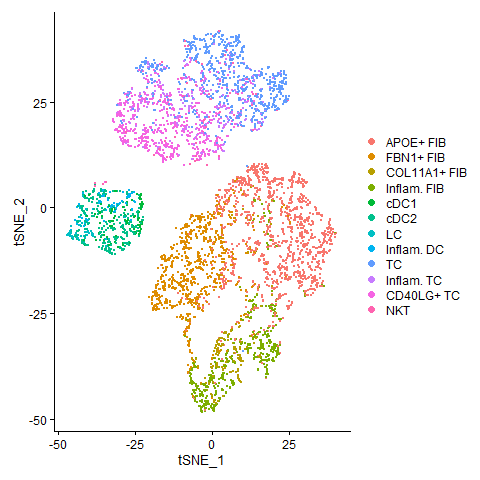

In [11]:
%%R 

set.seed(42)
LS <- CreateSeuratObject(data.input, project = 'LS', meta.data = meta)
Idents(LS) <- LS$labels
LS <- FindVariableFeatures(LS, nfeatures=2500, verbose = F)
LS <- ScaleData(LS, verbose = F) 
LS <- RunPCA(LS, verbose = F)
LS <- RunTSNE(LS)
TSNEPlot(LS)
#VariableFeaturePlot(object = LS)

R[write to console]: When using repel, set xnudge and ynudge to 0 for optimal results



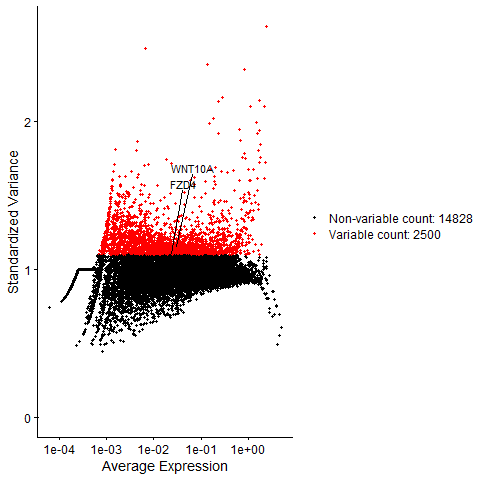

In [12]:
%%R
top <- head(VariableFeatures(LS), 50)
#png('HVG_examples.png', width = 4000, height = 4000, res = 300)
plot1 <- VariableFeaturePlot(object = LS)
LabelPoints(plot = plot1, points = c('WNT10A', 'FZD4'), repel = TRUE, xnudge=0.3, ynudge=0.5, max.overlaps = Inf)

#CombinePlots(plots = list(plot1, plot2))
#dev.off()

In [13]:
%%R -o counts -o HVGenes -o Genes -o Cells

counts <- GetAssayData(LS, slot = 'data')
Genes <- rownames(counts)
HVGenes <- rownames(GetAssayData(LS, slot = 'scale.data'))
Cells <- colnames(counts)


In [14]:
%%R -o LS

LS <- as.SingleCellExperiment(LS)

In [15]:
from scipy.sparse import csr_matrix
counts = csr_matrix.toarray(counts)

In [16]:
counts.shape

(17328, 5011)

### log data

In [17]:
ada = AnnData(counts.T)
ada.obs['barcodes'] = np.array(Cells)
ada.obs['ident'] = np.array(labels)
ada.var['gene_symbols'] = np.array(Genes)

ada.obs_names = ada.obs['barcodes']
ada.var_names = ada.var['gene_symbols']
#print(ada.isview)
ada = ada[:, ada.var_names.isin(HVGenes)].copy() #Not ArrayView

ada

AnnData object with n_obs × n_vars = 5011 × 2500
    obs: 'barcodes', 'ident'
    var: 'gene_symbols'

### Xct

In [18]:
ada.obs['ident'].unique()

array(['Inflam. FIB', 'FBN1+ FIB', 'APOE+ FIB', 'COL11A1+ FIB', 'cDC2',
       'LC', 'Inflam. DC', 'cDC1', 'CD40LG+ TC', 'Inflam. TC', 'TC',
       'NKT'], dtype=object)

In [19]:
CellA = 'Inflam. FIB'
CellB = 'Inflam. DC'

In [20]:
def XctInfo(CellA, CellB, permute = False, verbose = False):
    result = {}
    AB = ada[ada.obs['ident'].isin([CellA, CellB]), :]
    
    if permute:
        #np.random.seed(42)
        labels_pmt = np.random.permutation(AB.obs['ident'])
        AB.obs['ident'] = labels_pmt
        if verbose:
            print('Cell A and B permutated')
    #print(AB.obs['ident'][:30].unique(), AB.obs['ident'][-30:].unique()) #check
            
    A = AB[AB.obs['ident'] == CellA, :]
    B = AB[AB.obs['ident'] == CellB, :]
    #print(A.shape, B.shape)
   
    l_exp = []
    l_var = []
    for l in LRs['ligand']:
        if l not in np.array(A.var_names):
            l_exp.append(np.nan)
            l_var.append(np.nan)
        else:
            l_exp.append(np.mean(A[:, A.var_names.isin([l])].X))
            l_var.append(np.var(A[:, A.var_names.isin([l])].X))
    result['l_exp'] = l_exp
    result['l_var'] = l_var
    
    for rec in ['rec_A', 'rec_B', 'rec_C']:
        r_exp = []
        r_var = []
        for r in LRs[rec]:
            if r not in np.array(B.var_names):
                r_exp.append(np.nan)
                r_var.append(np.nan)
            else:
                r_exp.append(np.mean(B[:, B.var_names.isin([r])].X)) #mean expression of L and R
                r_var.append(np.var(B[:, B.var_names.isin([r])].X))
        result['{}_exp'.format(rec)] = r_exp
        result['{}_var'.format(rec)] = r_var
    
    return result
        

In [21]:
def XctSelection(dict_AB, IsPmt = False, verbose = False): # if input is permutated dataset
    LRs_Xct = LRs.copy()  
    LRs_Xct = pd.concat([LRs_Xct, pd.DataFrame.from_dict(dict_AB)], axis=1)
    
    mask1 = np.invert(LRs_Xct[['l_exp', 'rec_A_exp']].isna().any(axis=1)) # remove NA
    LRs_Xct = LRs_Xct[mask1]
    if not IsPmt:
        mask2 = (LRs_Xct['l_exp'] > 0) & (LRs_Xct['rec_A_exp'] > 0) # remove 0 for original LR
        LRs_Xct = LRs_Xct[mask2]
    if verbose:
        print('Selected {} LR pairs'.format(LRs_Xct.shape[0]))
    
    LRs_Xct['rec_exp'] = LRs_Xct[['rec_A_exp', 'rec_B_exp', 'rec_C_exp']].max(axis=1) #mean for R
    LRs_Xct['rec_var'] = LRs_Xct[['rec_A_var', 'rec_B_var', 'rec_C_var']].max(axis=1) #var for R
     
    return LRs_Xct


### test run

In [22]:
test_orig = XctInfo(CellA, CellB, permute = False) #test for orig
test_orig.keys()

dict_keys(['l_exp', 'l_var', 'rec_A_exp', 'rec_A_var', 'rec_B_exp', 'rec_B_var', 'rec_C_exp', 'rec_C_var'])

In [23]:
pd.DataFrame.from_dict(test_orig).head() #test

,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [24]:
orig = XctSelection(test_orig, IsPmt = False, verbose = True)
orig.head() #test

Selected 6 LR pairs


,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var,rec_exp,rec_var
645,CCL,CCL19,CCR7,None,None,1.7382643,5.539186,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579
646,CCL,CCL21,CCR7,None,None,0.05082678,0.100430116,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579
711,CXCL,CXCL12,CXCR4,None,None,1.4257646,2.7257175,1.3560512,1.5149305,NaN,NaN,NaN,NaN,1.356051,1.514930
806,TNF,TNF,TNFRSF1B,None,None,0.0031172754,0.004693508,0.3725189,0.68993086,NaN,NaN,NaN,NaN,0.372519,0.689931
825,CD137,TNFSF9,TNFRSF9,None,None,0.0058077816,0.009628484,0.35003668,0.49893814,NaN,NaN,NaN,NaN,0.350037,0.498938


In [25]:
test = XctInfo(CellA, CellB, permute = True) #test for permute
test.keys()

Trying to set attribute `.obs` of view, copying.


dict_keys(['l_exp', 'l_var', 'rec_A_exp', 'rec_A_var', 'rec_B_exp', 'rec_B_var', 'rec_C_exp', 'rec_C_var'])

In [26]:
pd.DataFrame.from_dict(test).head() #test

,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [27]:
p = XctSelection(test, IsPmt = True, verbose = True)
p.head() #test

Selected 128 LR pairs


,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var,rec_exp,rec_var
155,WNT,WNT10A,FZD4,LRP5,None,0.0,0.0,0.06496386,0.18678427,NaN,NaN,NaN,NaN,0.064964,0.186784
205,WNT,WNT3,FZD4,LRP5,None,0.0,0.0,0.06496386,0.18678427,NaN,NaN,NaN,NaN,0.064964,0.186784
235,WNT,WNT6,FZD4,LRP5,None,0.0045207296,0.00987107,0.06496386,0.18678427,NaN,NaN,NaN,NaN,0.064964,0.186784
315,WNT,WNT10A,FZD4,LRP6,None,0.0,0.0,0.06496386,0.18678427,NaN,NaN,NaN,NaN,0.064964,0.186784
365,WNT,WNT3,FZD4,LRP6,None,0.0,0.0,0.06496386,0.18678427,NaN,NaN,NaN,NaN,0.064964,0.186784


### method1

In [28]:
def XctScore1(LRs_Xct):
    LRs_Xct['LR_score'] = LRs_Xct['l_exp'] * LRs_Xct['rec_exp']
    
    return LRs_Xct['LR_score'].to_numpy(dtype=float)


In [29]:
LRs_Selected = XctSelection(XctInfo(CellA, CellB, permute = False), IsPmt = False, verbose = True) #selected original LR pairs
orig_score = XctScore1(LRs_Selected)

Selected 6 LR pairs


In [30]:
orig_score[:2]

array([2.93508177, 0.08582168])

In [31]:
LRs_Selected.head()

,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var,rec_exp,rec_var,LR_score
645,CCL,CCL19,CCR7,None,None,1.7382643,5.539186,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579,2.9350817688639665
646,CCL,CCL21,CCR7,None,None,0.05082678,0.100430116,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579,0.08582167562069198
711,CXCL,CXCL12,CXCR4,None,None,1.4257646,2.7257175,1.3560512,1.5149305,NaN,NaN,NaN,NaN,1.356051,1.514930,1.9334097528479788
806,TNF,TNF,TNFRSF1B,None,None,0.0031172754,0.004693508,0.3725189,0.68993086,NaN,NaN,NaN,NaN,0.372519,0.689931,0.0011612440028824222
825,CD137,TNFSF9,TNFRSF9,None,None,0.0058077816,0.009628484,0.35003668,0.49893814,NaN,NaN,NaN,NaN,0.350037,0.498938,0.0020329365906889274


In [32]:
def XctScores(CellA, CellB, LRs, func, n=100): #func: score method, permute n times
    scores = []
    for _ in range(n):
        p = XctSelection(XctInfo(CellA, CellB, permute = True), IsPmt = True, verbose = False)
        scores.append(func(p.loc[list(set(p.index) & set(LRs.index))])) #filter


    assert all(len(i) == len(orig_score) for i in scores) #check if equal len of selected LR pairs
    return np.array(scores).T  #transpose for further looping

In [33]:
scores = XctScores(CellA, CellB, LRs_Selected, XctScore1, n=100)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

In [34]:
scores.shape, len(scores)

((6, 100), 6)

In [35]:
def Xct_PermuTest(orig_score, scores, p = 0.05):
    enriched_i = []
    pvals = []
    counts = []
    for i, dist in enumerate(scores):
        count = sum(orig_score[i] > value for value in dist)
        pval = 1- count/len(dist)
        pvals.append(pval)
        counts.append(count)
        
        if pval < p:
            enriched_i.append(i)
            pvals.append(pval)
            counts.append(count)
    
    return enriched_i, pvals, counts

In [36]:
enriched, pvals, counts = Xct_PermuTest(orig_score, scores)
#enriched, counts

In [37]:
LRs_Enriched = LRs_Selected.iloc[enriched, :]
LRs_Enriched

,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var,rec_exp,rec_var,LR_score
645,CCL,CCL19,CCR7,None,None,1.7382643,5.539186,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579,2.9350817688639665
646,CCL,CCL21,CCR7,None,None,0.05082678,0.100430116,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579,0.08582167562069198
711,CXCL,CXCL12,CXCR4,None,None,1.4257646,2.7257175,1.3560512,1.5149305,NaN,NaN,NaN,NaN,1.356051,1.514930,1.9334097528479788


In [38]:
counts

[100, 100, 100, 100, 100, 100, 0, 0, 56]

In [39]:
scores[:2]

array([[0.28285561, 0.29793743, 0.34620394, 0.47846359, 0.28616869,
        0.3586173 , 0.33972719, 0.29342256, 0.28376545, 0.14981923,
        0.55449736, 0.56106932, 0.3967899 , 0.15256736, 0.4810571 ,
        0.42183641, 0.20679134, 0.61814773, 0.50484451, 0.35693493,
        0.47482424, 0.21972386, 0.48026819, 0.30569885, 0.3050429 ,
        0.41690217, 0.39620812, 0.51394715, 0.31138571, 0.26570825,
        0.21754844, 0.26702459, 0.34753525, 0.27127638, 0.11682346,
        0.50948173, 0.30433537, 0.36321872, 0.46629034, 0.2894327 ,
        0.163694  , 0.14447624, 0.20527402, 0.48390448, 0.12569115,
        0.3876295 , 0.48920915, 0.22811473, 0.47106578, 0.25618483,
        0.30585608, 0.1268712 , 0.34140171, 0.22215701, 0.40605542,
        0.44998847, 0.1627509 , 0.33070501, 0.65830204, 0.41952363,
        0.34706127, 0.27284052, 0.49158037, 0.5548214 , 0.36554949,
        0.34092157, 0.43555444, 0.40427204, 0.49187287, 0.18720522,
        0.65449895, 0.39669427, 0.29244053, 0.63

In [40]:
LRs_Selected.iloc[0]

pathway_name                   CCL
ligand                       CCL19
rec_A                         CCR7
rec_B                         None
rec_C                         None
l_exp                    1.7382643
l_var                     5.539186
rec_A_exp                1.6885129
rec_A_var                1.9415792
rec_B_exp                      NaN
rec_B_var                      NaN
rec_C_exp                      NaN
rec_C_var                      NaN
rec_exp                   1.688513
rec_var                   1.941579
LR_score        2.9350817688639665
Name: 645, dtype: object

In [41]:
def vis(orig_score, scores, i, LRs = LRs_Selected, density = False): #index i in LRs_Selected
    print('LR pair: {} - {}'.format(LRs.iloc[i]['ligand'], LRs.iloc[i]['rec_A']))
    plt.hist(scores[i], density = density)
    plt.axvline(x = orig_score[i], color = 'r')
    plt.show()

LR pair: CCL19 - CCR7


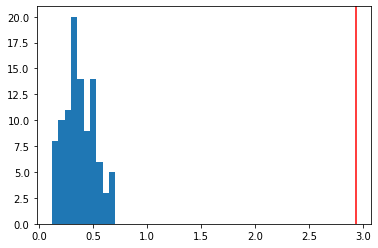

In [42]:
vis(orig_score, scores, 0, density = False)

### method2

In [43]:
def XctScore2(LRs_Xct):
    LRs_Xct['LR_score2'] = (LRs_Xct['l_exp']**2 + LRs_Xct['l_var']) * (LRs_Xct['rec_exp']**2 + LRs_Xct['rec_var'])
    
    return LRs_Xct['LR_score2'].to_numpy(dtype=float)

In [44]:
orig_score2 = XctScore2(LRs_Selected)

In [45]:
orig_score2[:2]

array([41.02871768,  0.49370807])

In [46]:
scores2 = XctScores(CellA, CellB, LRs_Selected, XctScore2, n=100)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

In [47]:
scores2[:2]

array([[2.37047283e+00, 5.12376170e+00, 7.78940449e+00, 3.25983191e+00,
        4.80518133e+00, 7.84842207e+00, 5.64341819e+00, 1.07093496e+01,
        5.55224535e+00, 3.68578855e+00, 1.27711251e+00, 5.02148652e+00,
        2.31632762e+00, 4.73285847e+00, 5.96587419e+00, 6.15265264e+00,
        4.58444184e+00, 4.03973822e+00, 3.26477779e+00, 6.02557452e+00,
        6.18985953e+00, 3.91807094e+00, 3.93739653e+00, 3.95267739e+00,
        5.18240565e+00, 4.48209117e+00, 3.55719046e+00, 7.09156668e+00,
        5.46118729e+00, 3.17567366e+00, 5.93063195e+00, 5.03118915e+00,
        6.21789470e+00, 2.68998015e+00, 5.33114763e+00, 3.01969058e+00,
        5.71437263e+00, 3.94423830e+00, 4.76152286e+00, 3.50962665e+00,
        4.54713014e+00, 4.97211046e+00, 6.86399398e+00, 5.66732600e+00,
        6.19211634e+00, 2.88845561e+00, 5.62088142e+00, 6.36829667e+00,
        4.37416817e+00, 6.16620074e+00, 5.71052821e+00, 4.24498192e+00,
        2.98764695e+00, 5.58083326e+00, 3.82195609e+00, 1.446703

In [48]:
enriched, pvals, counts = Xct_PermuTest(orig_score2, scores2)
LRs_Enriched2 = LRs_Selected.iloc[enriched, :]
LRs_Enriched2

,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var,rec_exp,rec_var,LR_score,LR_score2
645,CCL,CCL19,CCR7,None,None,1.7382643,5.539186,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579,2.9350817688639665,41.02871768335936
646,CCL,CCL21,CCR7,None,None,0.05082678,0.100430116,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579,0.08582167562069198,0.4937080726010155
711,CXCL,CXCL12,CXCR4,None,None,1.4257646,2.7257175,1.3560512,1.5149305,NaN,NaN,NaN,NaN,1.356051,1.514930,1.9334097528479788,15.959156709742594


In [49]:
counts

[100, 100, 100, 100, 100, 100, 6, 0, 95]

LR pair: CCL19 - CCR7


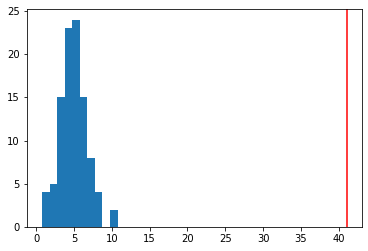

In [50]:
vis(orig_score2, scores2, 0)

### method 3

In [51]:
def XctScore3(LRs_Xct, k = 0.5):
    t = ((LRs_Xct['l_exp']**2 + LRs_Xct['l_var']) + (LRs_Xct['rec_exp']**2 + LRs_Xct['rec_var']).to_numpy(dtype=float))**(1/2)
    LRs_Xct['LR_score3'] = t / (k + t)
    
    return LRs_Xct['LR_score3'].to_numpy(dtype=float)

In [52]:
orig_score3 = XctScore3(LRs_Selected)

In [53]:
orig_score3[:2]

array([0.87964078, 0.81567607])

In [54]:
scores3 = XctScores(CellA, CellB, LRs_Selected, XctScore3, n=10)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [55]:
scores3[:2]

array([[0.84688756, 0.84831895, 0.84609442, 0.85616825, 0.8517506 ,
        0.85100092, 0.84689269, 0.85273897, 0.85248347, 0.85184249],
       [0.5611068 , 0.59258881, 0.57959016, 0.69898005, 0.62343941,
        0.64571628, 0.60046229, 0.65970229, 0.66060952, 0.64184122]])

In [56]:
enriched, pvals, counts = Xct_PermuTest(orig_score3, scores3)
LRs_Enriched3 = LRs_Selected.iloc[enriched, :]
LRs_Enriched3

,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var,rec_exp,rec_var,LR_score,LR_score2,LR_score3
645,CCL,CCL19,CCR7,None,None,1.7382643,5.539186,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579,2.9350817688639665,41.02871768335936,0.8796407805329439
646,CCL,CCL21,CCR7,None,None,0.05082678,0.100430116,1.6885129,1.9415792,NaN,NaN,NaN,NaN,1.688513,1.941579,0.08582167562069198,0.4937080726010155,0.8156760703701089
711,CXCL,CXCL12,CXCR4,None,None,1.4257646,2.7257175,1.3560512,1.5149305,NaN,NaN,NaN,NaN,1.356051,1.514930,1.9334097528479788,15.959156709742594,0.8506666884166839
806,TNF,TNF,TNFRSF1B,None,None,0.0031172754,0.004693508,0.3725189,0.68993086,NaN,NaN,NaN,NaN,0.372519,0.689931,0.0011612440028824222,0.0038975686009642455,0.6461203828016918


In [57]:
counts

[10, 10, 10, 10, 10, 10, 10, 10, 0, 8]

LR pair: CCL19 - CCR7


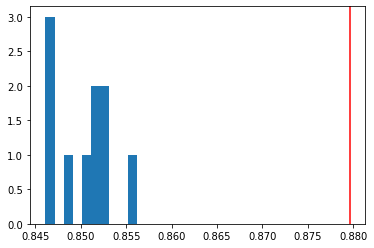

In [58]:
vis(orig_score3, scores3, 0)